In [144]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
import pandas as pd
sess = sagemaker.Session()
from matplotlib import pyplot as plt
import seaborn as sns
role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'qanv-aws-1' #sess.default_bucket() # Replace with your own bucket name if needed
print(bucket)
#prefix = 'blazingtext/supervised' #Replace with the prefix under which you want to store the data if needed
prefix = 'nlp/supervised' #Replace with the prefix under which you want to store the data if needed

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824
qanv-aws-1


In [9]:
!mkdir Data

In [2]:
!wget https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz

--2019-03-13 00:46:13--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.233.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.233.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688339454 (656M) [application/x-tar]
Saving to: ‘amazon_review_polarity_csv.tgz.1’

amazon_review_polar 100%[===================>] 656.45M  48.1MB/s    in 13s     

2019-03-13 00:46:26 (49.7 MB/s) - ‘amazon_review_polarity_csv.tgz.1’ saved [688339454/688339454]



In [3]:
 
!tar -xvzf amazon_review_polarity_csv.tgz
#df = pd.read_csv("amazon_review_polarity_csv/train.csv", names=["Label", "Title", "Review"])

amazon_review_polarity_csv/
amazon_review_polarity_csv/train.csv
amazon_review_polarity_csv/readme.txt
amazon_review_polarity_csv/test.csv


In [2]:
test_df = pd.read_csv("amazon_review_polarity_csv/test.csv", names=["Label", "Title", "Review"])

In [3]:
test_df.Label.value_counts()

2    200000
1    200000
Name: Label, dtype: int64

In [4]:
test_df.dtypes

Label      int64
Title     object
Review    object
dtype: object

In [5]:
test_df.sample(10)


,Label,Title,Review
149518,1,Poor Gilbert :-(,Poor Gilbert! He must have turned over in his ...
90156,1,too much of bad things can't be good,Usually I am able to fly through books by Larr...
32609,2,This is one nice cd.,Nas has done it again. This cd is all that. It...
175748,1,dont buy,This is trash I dont know who rates this devic...
221435,1,Not for technical use.,"If you want read guitar amp appreciation, this..."
316393,2,Written from the heart...,Mr. Sapoznik not only does an enviable job of ...
175026,1,Functional but not made to withstand travel,Its silly that this bag is so flimsy and not m...
309768,1,One of the worst....,I like her aerobics classes on TV but this boo...
71884,2,The Beasties have done it again!,"Wow, what a good CD! I really like the Beastie..."
143618,1,Sorry I bought it -- a one-time read at most,I saw several good reviews of this book but I ...


In [18]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
index_to_label = {'1': 'Negative', '2': 'Positive'}

In [8]:
def transform_instance(row):
    cur_row = []
    label = "__label__" + index_to_label[row[0]]  #Prefix the index-ed label with __label__
    cur_row.append(label)
    cur_row.extend(nltk.word_tokenize(row[1].lower()))
    cur_row.extend(nltk.word_tokenize(row[2].lower()))
    return cur_row

In [9]:
def preprocess(input_file, output_file, keep=1):
    all_rows = []
    with open(input_file, 'r') as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=',')
        for row in csv_reader:
            all_rows.append(row)
    shuffle(all_rows)
    all_rows = all_rows[:int(keep*len(all_rows))]
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, all_rows)
    pool.close() 
    pool.join()
    
    with open(output_file, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
        csv_writer.writerows(transformed_rows)

In [10]:
%%timeit
# Preparing the training dataset

# Since preprocessing the whole dataset might take a couple of mintutes,
# we keep 20% of the training dataset for this demo.
# Set keep to 1 if you want to use the complete dataset
preprocess('amazon_review_polarity_csv/train.csv', 'polarity.train', keep=.2)
        
# Preparing the validation dataset        
preprocess('amazon_review_polarity_csv/test.csv', 'polarity.validation')

1min 27s ± 1.88 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='polarity.train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='polarity.validation', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 25.3 µs


In [10]:
region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))


Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [11]:
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         base_job_name = 'qanv',
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)
bt_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)


In [12]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

In [13]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: qanv-2019-03-14-15-37-33-040


2019-03-14 15:37:33 Starting - Starting the training job...
2019-03-14 15:37:34 Starting - Launching requested ML instances......
2019-03-14 15:38:40 Starting - Preparing the instances for training......
2019-03-14 15:39:58 Downloading - Downloading input data
2019-03-14 15:39:58 Training - Training image download completed. Training in progress..
Arguments: train
[03/14/2019 15:39:59 WARNING 140134656247616] Loggers have already been setup.
[03/14/2019 15:39:59 WARNING 140134656247616] Loggers have already been setup.
[03/14/2019 15:39:59 INFO 140134656247616] nvidia-smi took: 0.0251681804657 secs to identify 0 gpus
[03/14/2019 15:39:59 INFO 140134656247616] Running single machine CPU BlazingText training using supervised mode.
[03/14/2019 15:39:59 INFO 140134656247616] Processing /opt/ml/input/data/train/polarity.train . File size: 316 MB
[03/14/2019 15:39:59 INFO 140134656247616] Processing /opt/ml/input/data/validation/polarity.validation . File size: 176 MB
Read 10M words
Read 20M

In [16]:
text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2019-03-14-15-48-15-249
INFO:sagemaker:Creating endpoint with name qanv-2019-03-14-15-37-33-040


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-east-1:023375022819:endpoint/qanv-2019-03-14-15-37-33-040".

In [154]:
#sentences = ["this python book is easy to use and it has number of useful examples."]
#sentences = ["this book is very bad and full of erros."]
sentences = ["I currently live in Europe, and this is the book I recommend for my visitors. It covers many countries, colour pictures, and is a nice starter for before you go, and once you are there."]

# using the same nltk tokenizer that we used during data preparation for training
tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances" : tokenized_sentences}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "prob": [
      0.9999270439147949
    ],
    "label": [
      "__label__Positive"
    ]
  }
]


In [24]:
predictions[0].get('prob')[0]


0.9999808073043823

In [26]:
predictions[0].get('label')[0][9:]


'Positive'

In [ ]:
#sess.delete_endpoint(text_classifier.endpoint)

## test

In [164]:
# read test data
test_data = pd.read_csv("/home/ec2-user/SageMaker/amazon_review_polarity_csv/test.csv", names=["Label", "Title", "Review"],nrows=10000)

In [165]:
test_data.shape

(10000, 3)

In [160]:
def get_inference(sentences):
    #print(sentences)
    sentences = [sentences.lower()]
     # using the same nltk tokenizer that we used during data preparation for training
    tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in sentences]
    #print(tokenized_sentences)
    payload = {"instances" : tokenized_sentences}

    response = text_classifier.predict(json.dumps(payload))

    predictions = json.loads(response)
    proba = predictions[0].get('prob')[0]
    label = predictions[0].get('label')[0][9:]
    if label == 'Positive':
        resp = 2
    else:
        resp = 1
    return (proba, resp)


In [155]:
get_inference("I currently live in Europe, and this is the book I recommend for my visitors. It covers many countries, colour pictures, and is a nice starter for before you go, and once you are there.")

(0.9999712705612183, 2)

In [ ]:
all_rows=test_data.Reviews
pool = Pool(processes=multiprocessing.cpu_count())
predictions = pool.map(get_inference, all_rows)
pool.close() 
pool.join()

In [158]:
get_inference(test_data.Review[10])

['i currently live in europe , and this is the book i recommend for my visitors . it covers many countries , colour pictures , and is a nice starter for before you go , and once you are there .']


(0.9999712705612183, 2)

In [166]:
test_data['Proba','Predict'] = test_data.Review.map(get_inference)

In [150]:
test_data.

(0.9512832760810852, 1)

In [163]:
test_data.dtypes


Label               int64  
Title               object 
Review              object 
Prediction          object 
prob                float64
pred_lbl            int64  
positive_prob       float64
(Proba, Predict)    object 
dtype: object

In [167]:
test_data.columns=['Label','Title','Review','Prediction']

In [168]:
prob = []
lbl = []
for v in test_data.Prediction.values:
    prob.append(v[0])
    lbl.append(v[1])

In [169]:
test_data['prob'] = pd.Series(prob)
test_data['pred_lbl'] = pd.Series(lbl)

In [170]:
test_data['positive_prob'] = test_data.Prediction.map(lambda v: 1-v[0] if v[1]==1 else v[0])

In [151]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', 900)

In [171]:
#list(zip(test_data.Label,test_data.pred_lbl))
test_data

,Label,Title,Review,Prediction,prob,pred_lbl,positive_prob
0,2,Great CD,"My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing ""Who was that singing ?""","(0.8200163245201111, 2)",0.820016,2,8.200163e-01
1,2,One of the best game music soundtracks - for a game I didn't really play,"Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of songs in my other video game soundtracks. I must admit that one of the songs (Life-A Distant Promise) has brought tears to my eyes on many occasions.My one complaint about this soundtrack is that they use guitar fretting effects in many of the songs, which I find distracting. But even if those weren't included I would still consider the collection worth it.","(0.9995580315589905, 2)",0.999558,2,9.995580e-01
2,1,Batteries died within a year ...,"I bought this charger in Jul 2003 and it worked OK for a while. The design is nice and convenient. However, after about a year, the batteries would not hold a charge. Might as well just get alkaline disposables, or look elsewhere for a charger that comes with batteries that have better staying power.","(1.0000001192092896, 1)",1.000000,1,-1.192093e-07
3,2,"works fine, but Maha Energy is better","Check out Maha Energy's website. Their Powerex MH-C204F charger works in 100 minutes for rapid charge, with option for slower charge (better for batteries). And they have 2200 mAh batteries.","(0.7688354253768921, 2)",0.768835,2,7.688354e-01
4,2,Great for the non-audiophile,"Reviewed quite a bit of the combo players and was hesitant due to unfavorable reviews and size of machines. I am weaning off my VHS collection, but don't want to replace them with DVD's. This unit is well built, easy to setup and resolution and special effects (no progressive scan for HDTV owners) suitable for many people looking for a versatile product.Cons- No universal remote.","(0.9962092041969299, 2)",0.996209,2,9.962092e-01
5,1,DVD Player crapped out after one year,"I also began having the incorrect disc problems that I've read about on here. The VCR still works, but hte DVD side is useless. I understand that DVD players sometimes just quit on you, but after not even one year? To me that's a sign on bad quality. I'm giving up JVC after this as well. I'm sticking to Sony or giving another brand a shot.","(0.9999784231185913, 1)",0.999978,1,2.157688e-05
6,1,Incorrect Disc,"I love the style of this, but after a couple years, the DVD is giving me problems. It doesn't even work anymore and I use my broken PS2 Now. I wouldn't recommend this, I'm just going to upgrade to a recorder now. I wish it would work but I guess i'm giving up on JVC. I really did like this one... before it stopped working. The dvd player gave me problems probably after a year of having it.","(0.9988870024681091, 1)",0.998887,1,1.112998e-03
7,1,DVD menu select problems,"I cannot scroll through a DVD menu that is set up vertically. The triangle keys will only select horizontally. So I cannot select anything on most DVD's besides play. No special features, no language select, nothing, just play.","(0.9378569722175598, 1)",0.937857,1,6.214303e-02
8,2,Unique Weird Orientalia from the 1930's,"Exotic tales of the Orient from the 1930's. ""Dr Shen Fu"", a Weird Tales mag

In [172]:
from sklearn.metrics import confusion_matrix, classification_report
print(pd.crosstab(test_data.Label,test_data.pred_lbl, \
                  rownames=['Actual'], colnames=['Predicted']))
print(classification_report(test_data.Label, test_data.pred_lbl))

Predicted     1     2
Actual               
1          4414  461 
2          424   4701
             precision    recall  f1-score   support

          1       0.91      0.91      0.91      4875
          2       0.91      0.92      0.91      5125

avg / total       0.91      0.91      0.91     10000



In [133]:
# AUC
from sklearn.metrics import roc_auc_score, roc_curve

In [173]:
rocauc= roc_auc_score(test_data.Label-1, test_data.positive_prob)

AUC:  0.9659116547842402


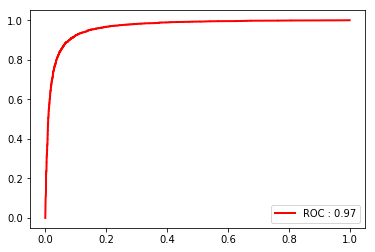

In [174]:
fpt, tpr, threshold = roc_curve(test_data.Label-1, test_data.positive_prob)
print('AUC: ', rocauc)
##              ROC curve
plt.plot(fpt, tpr, color = 'red', lw=2,
         label = "ROC : %0.2f" %(rocauc))
plt.legend(loc='lower right')
plt.show()